In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

Read the training and testing  dataset into the dataframe

In [2]:
import os
import pandas as pd

# Define directories for training and testing data
train_data_dir ="C:\\Users\\naren\\OneDrive\\ML\\Braintumordataset\\Training"
test_data_dir ="C:\\Users\\naren\\OneDrive\\ML\\Braintumordataset\\Testing"

def read_data_into_df(data_dir):
    filepaths = []
    labels = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        filepaths.extend([os.path.join(folder_path, file) for file in os.listdir(folder_path)])
        labels.extend([folder] * len(os.listdir(folder_path)))
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Read training and testing data into DataFrames
train_df = read_data_into_df(train_data_dir)
test_df = read_data_into_df(test_data_dir)



In [3]:
train_df
test_df

,filepaths,labels
0,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,glioma
1,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,glioma
2,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,glioma
3,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,glioma
4,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,glioma
...,...,...
1306,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,pituitary
1307,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,pituitary
1308,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,pituitary
1309,C:\Users\naren\OneDrive\ML\Braintumordataset\T...,pituitary



Data preprocessing

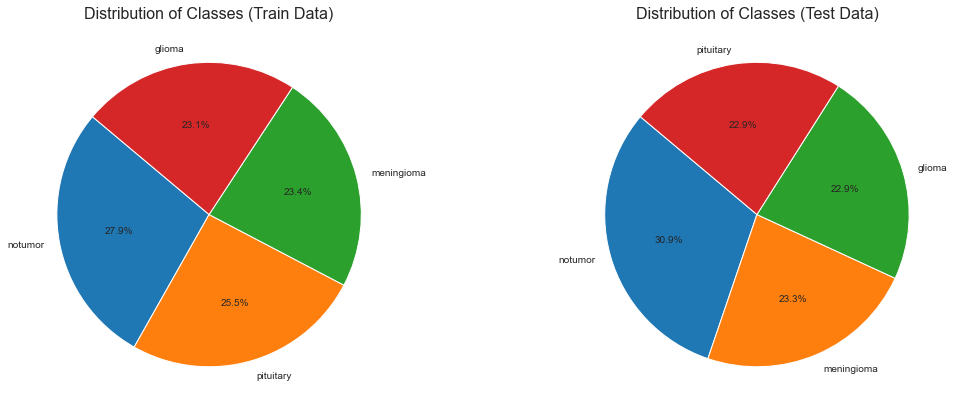

In [4]:
# Calculate count of images in each class for train and test data
train_class_counts = train_df['labels'].value_counts()
test_class_counts = test_df['labels'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot pie chart for train data
axes[0].pie(train_class_counts, labels=train_class_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Distribution of Classes (Train Data)', fontsize=16)

# Plot pie chart for test data
axes[1].pie(test_class_counts, labels=test_class_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Distribution of Classes (Test Data)', fontsize=16)

plt.show()


In [5]:
# Check if the dataset is balanced or not
is_balanced = train_class_counts.min() / train_class_counts.max() >= 0.8
if is_balanced:
    print("The training data is balanced.")
else:
    print("The training data is imbalanced.")


The training data is balanced.


In [6]:
from sklearn.model_selection import train_test_split

# Split the testing data into test and validation sets
test_split_df, val_split_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Display the number of samples in each set
print("Number of samples in test set:", len(test_split_df))
print("Number of samples in validation set:", len(val_split_df))


Number of samples in test set: 655
Number of samples in validation set: 656


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define parameters for image data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,        
    shear_range=0.2,     
    height_shift_range=0.2,   
    width_shift_range=0.2,    
    zoom_range=0.2,           
    horizontal_flip=True,     
    vertical_flip=True,       
    fill_mode='nearest' )

# Create generators for training, testing, and validation dataframes
train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col='filepaths', y_col='labels', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
test_generator = datagen.flow_from_dataframe(dataframe=test_split_df, x_col='filepaths', y_col='labels', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)
val_generator = datagen.flow_from_dataframe(dataframe=val_split_df, x_col='filepaths', y_col='labels', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

# Convert generators to numpy arrays
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [14]:
# Display shapes of numpy arrays
print("Shape of train images:", train_images.shape)
print("Shape of train labels:", train_labels.shape)
print("Shape of test images:", test_images.shape)
print("Shape of test labels:", test_labels.shape)
print("Shape of validation images:", val_images.shape)
print("Shape of validation labels:", val_labels.shape)

Shape of train images: (32, 224, 224, 3)
Shape of train labels: (32, 4)
Shape of test images: (32, 224, 224, 3)
Shape of test labels: (32, 4)
Shape of validation images: (32, 224, 224, 3)
Shape of validation labels: (32, 4)


Display Some image in Training Data

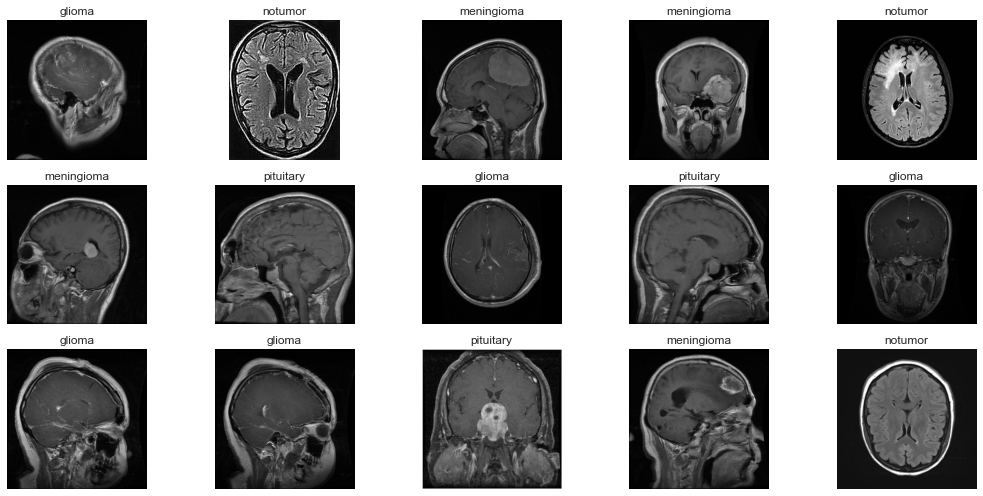

In [15]:
import matplotlib.pyplot as plt
import cv2

# Display multiple images from the training dataset in grayscale
num_images = 15
num_rows = 3
num_cols = num_images // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

for i, (img_path, img_label) in enumerate(train_df.sample(num_images).itertuples(index=False)):
    row = i // num_cols
    col = i % num_cols
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    axes[row, col].imshow(img, cmap='gray')  # Display the grayscale image
    axes[row, col].set_title(img_label)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Assuming img_size and channels are defined earlier
img_size = (224, 224)
channels = 3
class_count = len(train_generator.class_indices)

model = Sequential([
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(img_size[0], img_size[1], channels)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(128, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, (3, 3), padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(class_count, activation="softmax")
])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 128)      0

In [18]:
epochs = 15

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_CNN  = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_generator,
                    shuffle=False)


Epoch 1/15
179/179 [==============================] - 375s 2s/step - loss: 1.1569 - accuracy: 0.4273 - val_loss: 1.0556 - val_accuracy: 0.5747
Epoch 2/15
179/179 [==============================] - 352s 2s/step - loss: 0.9887 - accuracy: 0.5734 - val_loss: 0.9921 - val_accuracy: 0.5671
Epoch 3/15
179/179 [==============================] - 344s 2s/step - loss: 0.8958 - accuracy: 0.6239 - val_loss: 0.9026 - val_accuracy: 0.6067
Epoch 4/15
179/179 [==============================] - 342s 2s/step - loss: 0.7948 - accuracy: 0.6786 - val_loss: 0.8823 - val_accuracy: 0.6326
Epoch 5/15
179/179 [==============================] - 353s 2s/step - loss: 0.7320 - accuracy: 0.6942 - val_loss: 0.7731 - val_accuracy: 0.6555
Epoch 6/15
179/179 [==============================] - 415s 2s/step - loss: 0.7201 - accuracy: 0.7108 - val_loss: 0.7711 - val_accuracy: 0.6784
Epoch 7/15
179/179 [==============================] - 507s 3s/step - loss: 0.6773 - accuracy: 0.7227 - val_loss: 0.6475 - val_accuracy: 0.7241

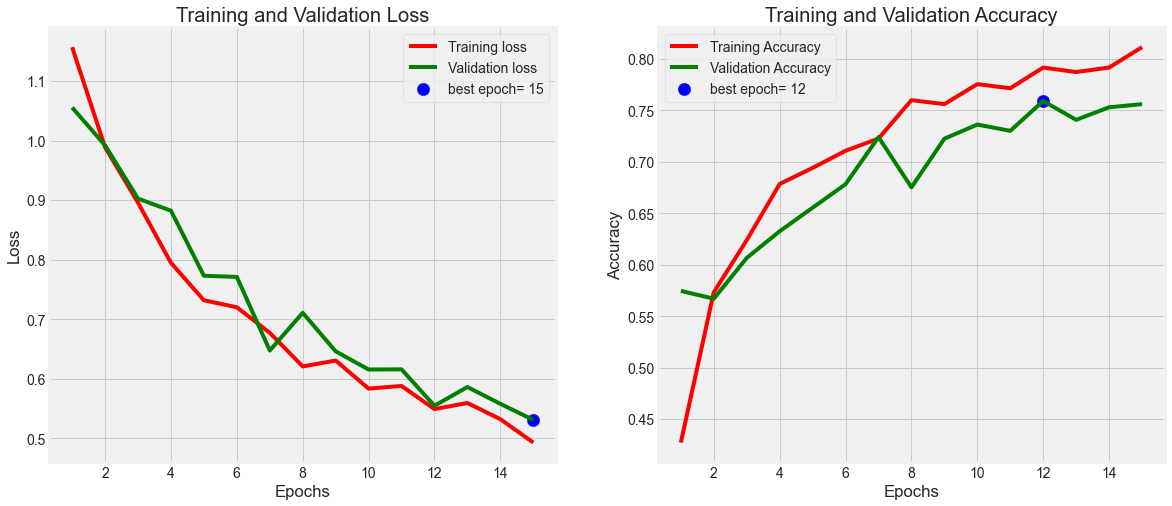

In [22]:
# Define needed variables
tr_acc = history_CNN.history['accuracy']
tr_loss = history_CNN.history['loss']
val_acc = history_CNN.history['val_accuracy']
val_loss = history_CNN.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [23]:
# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
valid_loss, val_acc = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Training Accuracy CNN : {train_accuracy*100:.2f}%")
print(f"Training Loss CNN : {train_loss*100:.2f}%")
print('-' * 20)
print("Validation Accuracy CNN: {:.2f}%".format(val_acc * 100))
print("Validation Loss CNN: {:.2f}%".format(valid_loss * 100))
print('-' * 20)
print("Test Accuracy CNN:", test_acc)
print("Test Accuracy CNN:", test_loss)

20/20 [==============================] - 20s 1s/step - loss: 0.4893 - accuracy: 0.8016
Training Accuracy CNN : 84.69%
Training Loss CNN : 41.04%
--------------------
Validation Accuracy CNN: 76.25%
Validation Loss CNN: 54.24%
--------------------
Test Accuracy CNN: 0.801562488079071
Test Accuracy CNN: 0.4892764985561371


In [26]:
preds = model.predict(test_generator)  
y_pred = np.argmax(preds, axis=1) 

21/21 [==============================] - 13s 584ms/step


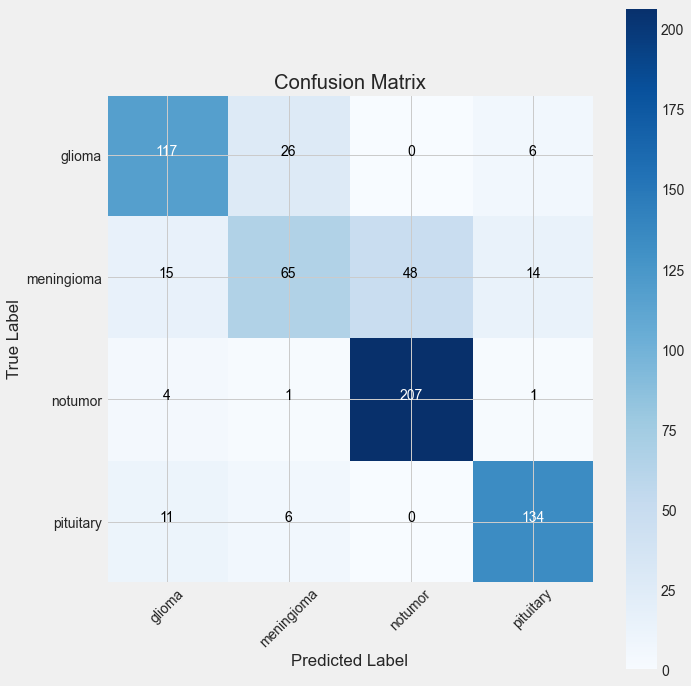

In [38]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [28]:
# Classification report
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.80      0.79      0.79       149
  meningioma       0.66      0.46      0.54       142
     notumor       0.81      0.97      0.88       213
   pituitary       0.86      0.89      0.88       151

    accuracy                           0.80       655
   macro avg       0.78      0.78      0.77       655
weighted avg       0.79      0.80      0.79       655




**ResNet **

In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define input shape
input_shape = (224, 224, 3)

# Load pre-trained ResNet50 model without top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(class_count, activation='softmax')(x)

# Combine base model and top layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 3s 0us/step


In [30]:
history_Resnet = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_generator,
                    shuffle=False)


Epoch 1/15
179/179 [==============================] - 517s 3s/step - loss: 1.1748 - accuracy: 0.4270 - val_loss: 1.2027 - val_accuracy: 0.4299
Epoch 2/15
179/179 [==============================] - 520s 3s/step - loss: 1.0917 - accuracy: 0.5030 - val_loss: 1.1646 - val_accuracy: 0.4634
Epoch 3/15
179/179 [==============================] - 528s 3s/step - loss: 1.0541 - accuracy: 0.5266 - val_loss: 1.1805 - val_accuracy: 0.4817
Epoch 4/15
179/179 [==============================] - 509s 3s/step - loss: 1.0448 - accuracy: 0.5259 - val_loss: 1.1661 - val_accuracy: 0.4970
Epoch 5/15
179/179 [==============================] - 521s 3s/step - loss: 1.0323 - accuracy: 0.5392 - val_loss: 1.1222 - val_accuracy: 0.5213
Epoch 6/15
179/179 [==============================] - 512s 3s/step - loss: 1.0111 - accuracy: 0.5478 - val_loss: 1.1906 - val_accuracy: 0.4405
Epoch 7/15
179/179 [==============================] - 538s 3s/step - loss: 1.0119 - accuracy: 0.5502 - val_loss: 1.0862 - val_accuracy: 0.5305

In [32]:
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [43]:
# Evaluate on training set
train_loss_Res, train_acc_Res = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
# Evaluate on validation set
valid_loss_Res, val_acc_Res = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
# Evaluate on test set
test_loss_Res, test_acc_Res = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)


print("Training Accuracy ResNet :", train_acc_Res)
print('Training Loss ResNet :', train_loss_Res)
print("Validation Accuracy ResNet :", val_acc_Res)
print('Validation Loss ResNet :', valid_loss_Res)
print("Test Accuracy ResNet :", test_acc_Res)
print('Testing Loss ResNet :', test_loss_Res)

20/20 [==============================] - 46s 2s/step - loss: 1.2147 - accuracy: 0.4781
Training Accuracy ResNet : 0.5031601190567017
Training Loss ResNet : 1.1297281980514526
Validation Accuracy ResNet : 0.46875
Validation Loss ResNet : 1.2517406940460205
Test Accuracy ResNet : 0.4781250059604645
Testing Loss ResNet : 1.2147122621536255


In [44]:
preds = model.predict(test_generator)  
y_pred = np.argmax(preds, axis=1) 

21/21 [==============================] - 36s 2s/step


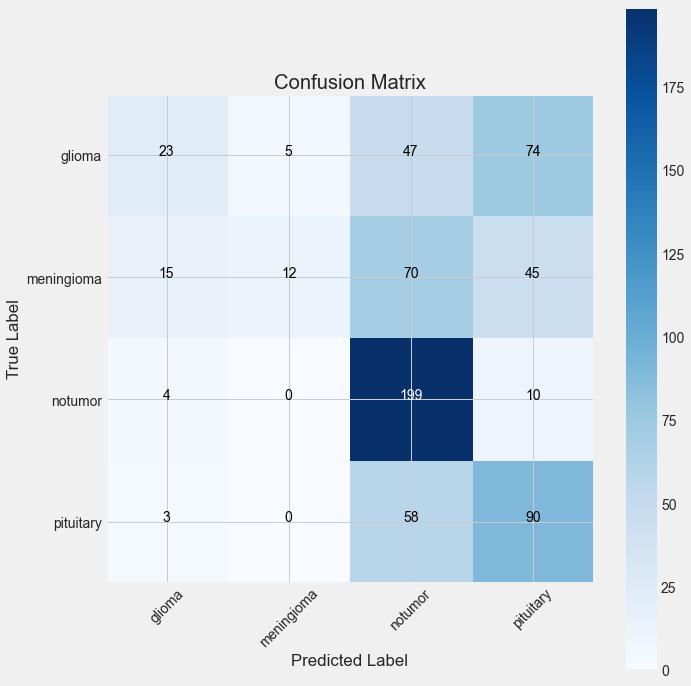

In [45]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [46]:
# Classification report
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
print(classification_report(test_generator.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.51      0.15      0.24       149
  meningioma       0.71      0.08      0.15       142
     notumor       0.53      0.93      0.68       213
   pituitary       0.41      0.60      0.49       151

    accuracy                           0.49       655
   macro avg       0.54      0.44      0.39       655
weighted avg       0.54      0.49      0.42       655



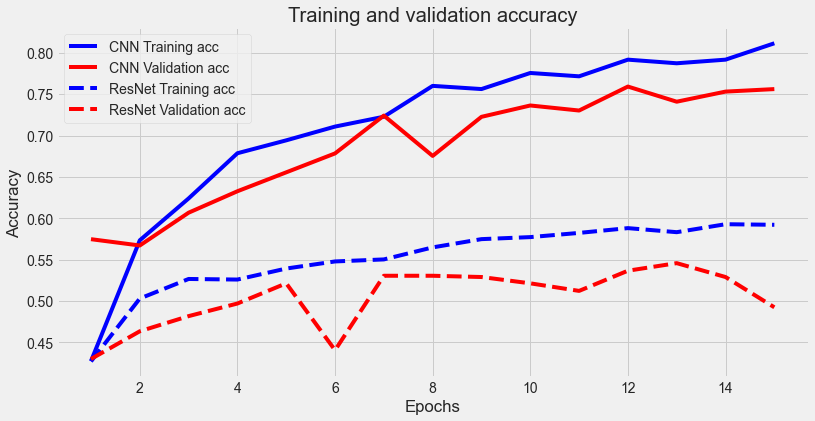

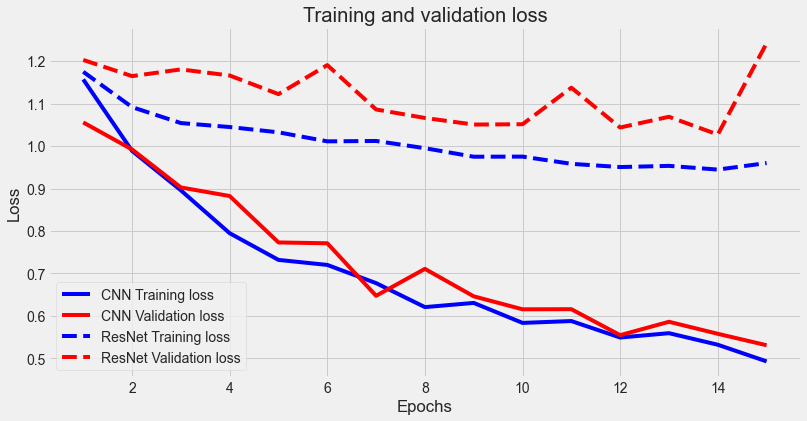

In [52]:
import matplotlib.pyplot as plt

# Extracting performance metrics for CNN model
tr_acc_cnn = history_CNN.history['accuracy']
val_acc_cnn = history_CNN.history['val_accuracy']
tr_loss_cnn = history_CNN.history['loss']
val_loss_cnn = history_CNN.history['val_loss']

# Extracting performance metrics for ResNet model
tr_acc_resnet = history_Resnet.history['accuracy']
val_acc_resnet = history_Resnet.history['val_accuracy']
tr_loss_resnet = history_Resnet.history['loss']
val_loss_resnet = history_Resnet.history['val_loss']

# Define epochs
epochs = range(1, len(tr_acc_cnn) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, tr_acc_cnn, 'b', label='CNN Training acc')
plt.plot(epochs, val_acc_cnn, 'r', label='CNN Validation acc')
plt.plot(epochs, tr_acc_resnet, 'b--', label='ResNet Training acc')
plt.plot(epochs, val_acc_resnet, 'r--', label='ResNet Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, tr_loss_cnn, 'b', label='CNN Training loss')
plt.plot(epochs, val_loss_cnn, 'r', label='CNN Validation loss')
plt.plot(epochs, tr_loss_resnet, 'b--', label='ResNet Training loss')
plt.plot(epochs, val_loss_resnet, 'r--', label='ResNet Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
